In [1]:
import sympy as sp
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
from sympy import cos, sin, exp, Matrix, sqrt
from sympy.simplify.fu import TR10, TR9
import pandas as pd

from IPython.display import display, Math
from IPython.display import display as disp
from utils import symdisp, symplot
import ipywidgets as widgets
from ipywidgets import interact

from commpy.utilities import upsample

from optic.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp import firFilter, pulseShape, lowPassFIR, pnorm, sincInterp
from optic.metrics import signal_power
from optic.plot import eyediagram

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:,d}'.format

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
figsize(10, 4)

# Transmissão Digital da Informação

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#O-modelo-de-canal-AWGN" data-toc-modified-id="O-modelo-de-canal-AWGN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>O modelo de canal AWGN</a></span></li><li><span><a href="#Receptores-e-receptores-ótimos" data-toc-modified-id="Receptores-e-receptores-ótimos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Receptores e receptores ótimos</a></span><ul class="toc-item"><li><span><a href="#Demodulador-por-correlação" data-toc-modified-id="Demodulador-por-correlação-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Demodulador por correlação</a></span></li><li><span><a href="#Demodulador-por-filtro-casado" data-toc-modified-id="Demodulador-por-filtro-casado-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Demodulador por filtro casado</a></span><ul class="toc-item"><li><span><a href="#Filtro-casado" data-toc-modified-id="Filtro-casado-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Filtro casado</a></span></li><li><span><a href="#Maximização-da-$\mathrm{SNR}$" data-toc-modified-id="Maximização-da-$\mathrm{SNR}$-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Maximização da $\mathrm{SNR}$</a></span></li></ul></li></ul></li><li><span><a href="#Referências" data-toc-modified-id="Referências-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Referências</a></span></li></ul></div>

# Receptores ótimos para canais AWGN

<img src="./figuras/Fig1.png" width="900">
 <center>Fig.1: Diagrama de blocos de um sistema de transmissão digital genérico.</center>

##  O modelo de canal AWGN

Considere o modelo de canal em que os sinais transmitidos são afetados apenas por ruído branco gaussiano aditivo (*additive white Gaussian noise* - AWGN). Nesse modelo, o ruído é representado por um processo aleatório gaussiano, ou seja, para cada instante $t$ no tempo, o ruído $n(t)$ adicionado ao sinal é dado por uma variável aleatória gaussiana de média $\mu$ igual a zero e com uma certa variância $\sigma^2$. Desse modo, seja $s(t)$ o sinal enviado pelo transmissor ao canal, o modelo de canal AWGN assume que um ruído $n(t)$ será adicionado ao sinal de informação durante o processo de comunicação, como indicado na figura a seguir

<img src="./figuras/Fig3.png" width="700">
<center>Fig.2: Esquemático de um sistema de transmissão digital via canal AWGN.</center>

em que $r(t)$ representa o sinal ruidoso na entrada do receptor.

Assuma que em cada intervalo de sinalização $T_s$, o transmissor envia um sinal $s_m(t)$ dentre os $M$ possíveis do esquema de modulação utilizado, i.e. $\left\lbrace s_m(t), m = 1,2,\dots, M\right\rbrace$. Considere que no intervalo de $0\leq t \leq T_s$ o transmissor enviou a sinal $s_m(t)$. Uma vez que o canal adiciona ruído ao sinal transmitido, o sinal recebido $r(t)$ no intervalo $0\leq t \leq T_s$ pode ser expresso como

$$\begin{equation}\label{awgnch_eq1} r(t) = s_m(t) + n(t)\end{equation}$$

em que $n(t)$ é uma função amostra de um processo estocástico gaussiano com densidade espectral de potência $S_n(f)=\frac{N_0}{2}$.

## Receptores e receptores ótimos

Baseado na observação de $r(t)$ durante o intervalo de sinalização, o receptor tem a tarefa de inferir qual dos $M$ possíveis sinais foi enviado pelo transmissor. Uma vez que o canal adiciona uma perturbação aleatória ao sinal transmitido, o processo de inferência passa a ter caráter probabilístico. Nesse sentido, sempre existe a possibilidade de que o canal altere a forma do sinal $s_m(t)$ de modo que o sinal recebido possa se assemelhar a um outro sinal do conjunto  $\left\lbrace s_m(t), m = 1,2,\dots, M\right\rbrace$ diferente do que foi transmitido. Logo, se o receptor assume que o sinal transmitido é aquele que tem maior proximidade com o sinal recebido, a presença de ruído pode levar a erros no processo de deteção da informação transmitida. O projeto de receptores ótimos, então, baseia-se no estabelecimento de esquemas de recepção que minimizem a probabilidade da ocorrência de erros no processo de decisão da informação transmitida atrabés do canal.

Como ilustrado na figura abaixo, a tarefa do receptor pode ser subdividida em duas partes:

* **Demodulação**: conversão do sinal recebido $r(t)$ em um vetor de amostras discretas $\mathbf{r} = [r_1,r_2,\dots, r_N]$, em que $N$ é a dimensão dos sinais transmitidos.

* **Detecção**: a partir de $\mathbf{r}$, decidir qual dos $M$ possíveis sinais foram transmitidos.

<img src="./figuras/Fig5.png" width="700">
<center>Fig.3: Estrutura de blocos de um receptor digital.</center>

Para entendermos a tarefa do demodulador, precisamos recorrer ao conceito de espaço de sinais. Considere que os sinais $s_m(t)$ gerados pelo transmissor possam ser expandidos a partir de uma base de $N$ funções ortonormais $f_n(t)$, isto é

$$\begin{equation} s_m(t) = \sum_{k=1}^{N}s_{mk}f_k(t) \end{equation}$$

em que o vetor $\mathbf{s}_m = [s_1, s_2, \dots, s_N]$ corresponde à representação de $s_m(t)$ na base ortonormal $\left\lbrace f_n(t) \right\rbrace_{n=1}^{N}$. Por base ortonormal, entende-se que o produto interno entre duas funções $f_i(t)$ e $f_j(t)$ quaisquer da base obedece a seguinte propriedade

$$\begin{equation} 
\langle f_i(t), f_j(t) \rangle = \int_{-\infty}^{\infty}f_i(t)f_j^*(t) dt = \begin{cases} 1, & \text{ se } i=j\\ 0, & \text{ se } i\neq j \end{cases} \end{equation} $$

em que $^*$ indica o conjugado complexo.

Assim, podemos decompor o sinal $s_m(t)$ em suas componentes vetorias $s_1, s_2, \dots, s_N$ na base $\left\lbrace f_n(t) \right\rbrace_{n=1}^{N}$ realizando o produto interno entre $s_m(t)$ e cada elemento da base no intervalo 
$0\leq t \leq T_s$:

$$\begin{equation} 
\langle s_m(t), f_i(t) \rangle = \int_{0}^{T}s_m(t)f_i^*(t) dt = s_i \end{equation} $$

em que $s_i$ é o componente vetorial de $s_m(t)$ na direção de $f_i(t)$.

### Demodulador por correlação

Na Fig.4 a estrutura de um demodulador por correlação está ilustrada. No receptor, o sinal recebido é correlacionado com cada uma das $N$ funções que compõem a base ortonormal $\left\lbrace f_k(t) \right\rbrace_{k=1}^{N}$, ou seja, cada correlator corresponde à operação

$$\begin{align} 
\langle r(t), f_k(t) \rangle =& \int_{0}^{T}r(t)f_k(t) dt \\
=& \int_{0}^{T}[s_m(t) + n(t)]f_k(t) dt \\
=& \int_{0}^{T}s_m(t)f_k(t)dt + \int_{0}^{T}n(t)f_k(t) dt\\
=& s_{mk} + n_k = r_k
\end{align} $$

com $k=1, 2,\dots, M$.

<img src="./figuras/Fig6.png" width="600">
<center>Fig.4: Demodulador por correlação.</center>

A partir das projeções de $r(t)$ e $n(t)$ nas funções da base ortonormal, podemos escrever

$$\begin{align} r(t) & =\sum_{k=1}^N s_{m k} f_k(t)+\sum_{k=1}^N n_k f_k(t)+n^{\prime}(t) \\ & =\sum_{k=1}^N r_k f_k(t)+n^{\prime}(t)\end{align}$$

em que $n^{\prime}(t)=n(t)-\sum_{k=1}^N n_k f_k(t)$ corresponde aos componentes do ruído que são ortogonais à base ortonormal utilizada na transmissão.

Utilizando as propriedades da média e da autocorrelação do processo estocástico gaussiano estacionário associado ao ruído, temos que:

$$\begin{equation}
E\left[n_k\right]=\int_0^{T_s} E[n(t)] f_k(t) dt=0
\end{equation}$$

e 

$$
\begin{align}
E\left[n_k n_m\right] & = E\left[ \int_0^{T_s} n(t) f_k(t) dt \int_0^{T_s} n(\tau) f_m(\tau) d\tau\right] \\
& = \int_0^{T_s} \int_0^{T_s} E[n(t) n(\tau)] f_k(t) f_m(\tau) d t d \tau \\
& =\frac{N_0}{2}  \int_0^{T_s} \int_0^{T_s} \delta(t-\tau) f_k(t) f_m(\tau) d t d \tau \\
& = \frac{N_0}{2} \int_0^{T_s} f_k(t) \left[\int_0^{T_s} \delta(t-\tau)  f_m(\tau) d \tau \right] d t \\
& =\frac{N_0}{2} \int_0^{T_s} f_k(t) f_m(t) d t \\
& =\frac{N_0}{2} \delta_{m k}
\end{align}
$$

Desse modo, os termos $n_k$ são variáveis aleatórias gaussianas independentes e identicamente distribuídas (i.i.d), com média nula e variância $\sigma_n^2 = E[n_k^2] = \frac{N_0}{2}$.

Assumindo que o sinal $s_m(t)$ seja conhecido, podemos descrever os sinais $r_k$ na saída dos correlatores como variáveis aleatórias gaussianas independentes de média:

$$
\begin{equation}
E\left[r_k\right]=E\left[s_{m k}+n_k\right]=s_{m k} 
\end{equation}
$$
e variância
$$
\begin{align}
\sigma_r^2 &= E\left[r_k^2\right] - E[r_k]^2 \\
&= E\left[s_{mk}^2 + 2s_{mk}n_k + n_k^2\right] - s_{mk}^2\\
&= s_{mk}^2 + E[n_k^2] - s_{mk}^2\\
&= \sigma_n^2=\frac{N_0}{2}.
\end{align}
$$

Portanto, o vetor $\mathbf{r}$ pode ser representado pela seguinte função densidade de probabilidade condicional conjunta

$$ \begin{equation}\label{pdf_conj_1}
p\left(\mathbf{r}|\mathbf{s}_m\right)=\prod_{k=1}^N p\left(r_k|s_{m k}\right), \quad m=1,2, \ldots, M
\end{equation} $$

em que cada componente vetorial possui distribuição condicional

$$\begin{equation}\label{pdf_conj_2}
p\left(r_k|s_{m k}\right)=\frac{1}{\sqrt{\pi N_0}} \exp \left[-\frac{\left(r_k-s_{mk}\right)^2}{N_0}\right], \quad k=1,2, \ldots, N.
\end{equation}$$

Substituindo ($\ref{pdf_conj_2}$) in ($\ref{pdf_conj_1}$), temos:

$$\begin{equation}\label{pdf_conj_3}
p\left(\mathbf{r}|\mathbf{s}_m\right)=\frac{1}{\left(\pi N_0\right)^{N/2}} \exp \left[-\sum_{k=1}^N \frac{\left(r_k-s_{m k}\right)^2}{N_0}\right], \quad m=1,2, \ldots, M
\end{equation}$$

Por fim, faz-se necessário demonstrar que $n^{\prime}(t)$ é irrelevante no processo de decisão sobre qual dos $M$ possíveis sinais foi enviado pelo transmissor. Para tanto, basta mostrar que $n^{\prime}(t)$ e as saídas dos correlatores $r_1, r_2, \dots, r_N$ são independentes. Uma vez que tanto $n^{\prime}(t)$ quanto $r_1, r_2, \dots, r_N$ tem estatística gaussiana, basta mostrar que estes são descorrelacionados. Desse, modo, temos:

$$\begin{aligned} 
E\left[n^{\prime}(t) r_k\right] &= E\left[n^{\prime}(t)\right] s_{m k}+E\left[n^{\prime}(t) n_k\right] \\
&=E\left[n^{\prime}(t) n_k\right] \\ 
&=E\left\{\left[n(t)-\sum_{j=1}^N n_j f_j(t)\right] n_k\right\} \\ 
&=E\left\{\left[n(t)n_k-\sum_{j=1}^N n_j n_k f_j(t)\right] \right\} \\ 
&=E\left\{\left[n(t)\int_0^T n(\tau) f_k(\tau) d\tau -\sum_{j=1}^N n_j n_k f_j(t)\right]  \right\} \\
&=\int_0^T E[n(t) n(\tau)] f_k(\tau) d \tau-\sum_{j=1}^N E\left[n_j n_k\right] f_j(t) \\ 
&=\frac{N_0}{2} f_k(t)-\frac{N_0}{2} f_k(t)=0
\end{aligned}$$

Logo, conclui-se que $n^{\prime}(t)$ e $r_1, r_2, \dots, r_N$ são estatisticamente independentes, sendo as saídas dos correlatores uma *estatística suficiente* para o detector decidir qual sinal foi enviado pelo transmissor. 

### Demodulador por filtro casado

De modo alternativo, o demodulador pode ser construído a partir de um banco de $N$ filtros lineares, como ilustrado na Fig.5. Assuma que a resposta ao impulso $h_k(t)$ de cada um dos $N$ filtros que compõem o banco seja dada por

$$ 
\begin{equation}
h_k(t)=f_k(T_s-t), \quad 0 \leqslant t \leqslant T
\end{equation}
$$

em que $\left\lbrace f_k(t) \right\rbrace_{k=1}^{N}$ são as $N$ funções da base orthonormal e que $h_k(t)=0$ fora do intervalo $0 \leqslant t \leqslant T$.

<img src="./figuras/Fig7.png" width="600">
<center>Fig.5: Demodulador por filtro casado.</center>

Seja $y_k(t)$ a saída do $k$-ésimo filtro, temos que

$$ \begin{align} 
y_k(t) & =\int_0^t r(\tau) h_k(t-\tau) d \tau \\ 
& =\int_0^t r(\tau) f_k(T_s-t+\tau) d \tau, \quad k=1,2, \ldots, N.
\end{align}$$

Se amostrarmos $y_k(t)$ no instante $t=T_s$, temos

$$\begin{equation}
y_k(T_s)=\int_0^t r(\tau) f_k(\tau) d t=r_k, \quad k=1,2, \ldots, N
\end{equation}$$

Desse modo, a saída dos filtros amostrada em $t=T_s$ provê a mesma sequência de valores $r_1, r_2, \dots, r_N$ obtida na saída do banco de correlatores.

#### Filtro casado
Um filtro cuja resposta ao impulso é dada por $h(t) = s(T_s - t)$, em que $s(t)$ está confinada ao intervalo $0\leq t \leq T_s$, é denominado **filtro casado** ao sinal $s(t)$.

$$
\begin{equation}
y(t)=\int_0^t s(\tau) s(T_s-t+\tau) d \tau
\end{equation}
$$

#### Maximização da $\mathrm{SNR}$

A mais importante característica de um filtro casado é que se o sinal $s(t)$ estiver afetado por ruído AWGN, o filtro cuja resposta ao impulso maximiza a $\mathrm{SNR}$ do sinal após a filtragem é o filtro casado de $s(t)$. Para demonstrar essa propriedade, considere que o sinal $r(t) = s(t) + n(t)$ na saída do canal AWGN passa por um filtro de resposta ao impulso $h(t)$. A saída $y(t)$ do filtro será dada por

$$
\begin{align}
y(t) & =\int_0^t r(\tau) h(t-\tau) d \tau \\
& =\int_0^t s(\tau) h(t-\tau) d \tau+\int_0^t n(\tau) h(t-\tau) d \tau.
\end{align}
$$

Amostrando a saída do filtro em $t=T_s$, temos

$$
\begin{align}
y(T_s) & = \int_0^{T_s} s(\tau)h(T_s-\tau)d\tau + \int_0^{T_s}n(\tau)h(T_s-\tau)d\tau\\
& = y_s(T_s)+y_n(T_s).
\end{align}
$$

Desse modo, podemos definir a $\mathrm{SNR}$ do sinal na saída do filtro como
$$
\begin{equation}\label{SNR_o}
\mathrm{SNR} = \frac{y_s^2(T_s)}{E\left[y_n^2(T_s)\right]},
\end{equation}
$$

em que o denominador $E\left[y_n^2(T_s)\right]$ corresponde à variância do ruído na saída do filtro, que podemos reescrever como:

$$
\begin{align}
E\left[y_n^2(T_s)\right] & =\int_0^{T_s} \int_0^{T_s} E[n(\tau) n(t)] h(T_s-\tau) h(T_s-t) d t d \tau \\
& =\frac{N_0}{2} \int_0^{T_s} \int_0^{T_s} \delta(t-\tau) h(T_s-\tau) h(T_s-t) d t d \tau \\
& =\frac{N_0}{2} \int_0^{T_s} h^2(T_s-t) d t.
\end{align}
$$

Logo, temos a seguinte expressão para a $\mathrm{SNR}$ na saída do filtro:
$$
\begin{equation}
\mathrm{SNR} =\frac{\left[\int_0^{T_s} s(\tau) h(T_s-\tau) d \tau\right]^2}{\frac{N_0}{2} \int_0^{T_s} h^2(T_s-t) d t}=\frac{\left[\int_0^{T_s} h(\tau) s(T_s-\tau) d \tau\right]^2}{\frac{N_0}{2} \int_0^{T_s} h^2(T_s-t) d t}.
\end{equation}
$$

Perceba que o termo  $\int_0^{T_s} h^2(T_s-t) d t$ no denominador corresponde à energia de $h(t)$, que pode ser mantida constante. Mantendo-se o denominador constante, a $\mathrm{SNR}$ será máxima se termo $\left[\int_0^{T_s} h(\tau) s(T_s-\tau) d \tau\right]^2$ do numerador for maximizado. Para tanto, considere o resultado da desigualdade de Cauchy-Schwarz que estabelece que para dois sinais $g_1(t)$ e $g_2(t)$ de energia finita 

$$
\begin{equation}
\left[\int_{-\infty}^{\infty} g_1(t) g_2(t) d t\right]^2 \leqslant \int_{-\infty}^{\infty} g_1^2(t) d t \int_{-\infty}^{\infty} g_2^2(t) d t
\end{equation}
$$

com igualdade se, e somente se, $g_1(t) = Cg_2(t)$, sendo $C$ uma constante arbitrária. Logo, a $\mathrm{SNR}$ será máxima quando $h(\tau) = Cs(T_s - \tau)$, ou seja, quando a resposta ao impulso $h(t)$ for casada ao sinal $s(t)$. Neste caso, tem-se que

$$
\begin{align}
\mathrm{SNR} & = \frac{\int_0^{T_s} C^2s^2(T_s-\tau) d \tau \int_0^{T_s}s^2(T_s-\tau) d \tau}{\frac{N_0}{2} \int_0^{T_s} C^2s^2(T_s-t) d t} \\
& =\frac{2}{N_0} \int_0^{T_s} s^2(T_s-\tau) d \tau \\
& =\frac{2}{N_0} \int_0^{T_s} s^2(t) d t \\
& = \frac{2E}{N_0}
\end{align}
$$

em que $E = \int_0^{T_s} s^2(t) d t$ é a energia do sinal $s(t)$. Portanto, a $\mathrm{SNR}$ depende apenas da energia do sinal $s(t)$ e não de qualquer outra característica do mesmo.

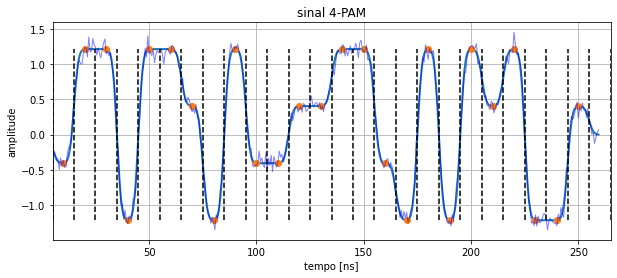

In [6]:
M = 4

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(25*np.log2(M)))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization
symbTx = np.insert(symbTx,0, 0)

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = sigTx.real

t = np.arange(0, sigTx.size)*(1/Fa)/1e-9

# instantes centrais dos intervalos de sinalização
symbolsUp = upsample(symbTx, SpS)
symbolsUp[symbolsUp==0] = np.nan

plt.figure(2)
plt.plot(t, sigTx,'-',linewidth=2)
plt.plot(t, symbolsUp.real,'o')
plt.xlabel('tempo [ns]')
plt.ylabel('amplitude')
plt.title('sinal '+str(M)+'-PAM')
plt.grid()

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.0050  # variância
μ   = 0      # média

σ      = sqrt(σ2) 
ruido  = normal(μ, σ, Namostras)

plt.figure(2)
plt.plot(t, sigTx + ruido,'b-',alpha=0.5, linewidth=1)

t = (0.5*Ts + np.arange(0, symbTx.size+1)*Ts)/1e-9
plt.vlines(t, min(symbTx), max(symbTx), linestyles='dashed', color = 'k');
plt.xlim(min(t), max(t));

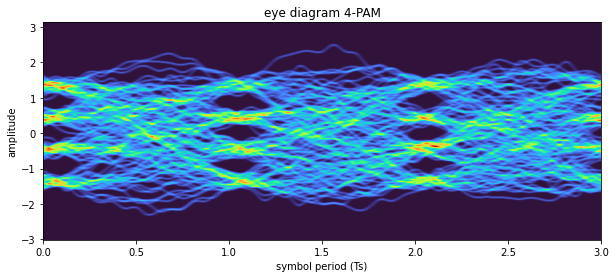

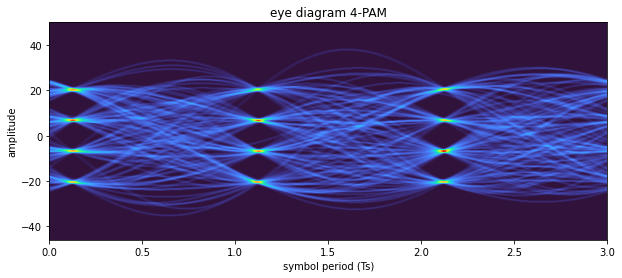

In [13]:
# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(250000*np.log2(M)))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('rrc', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = sigTx.real

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.0050  # variância
μ   = 0      # média

σ      = sqrt(σ2) 
ruido  = normal(μ, σ, Namostras)

# diagrama de olho
Nsamples = sigTx.size
eyediagram(sigTx+ruido, Nsamples, SpS, plotlabel= str(M)+'-PAM', ptype='fancy')
eyediagram(firFilter(pulse, sigTx+ruido), Nsamples, SpS, plotlabel= str(M)+'-PAM', ptype='fancy')

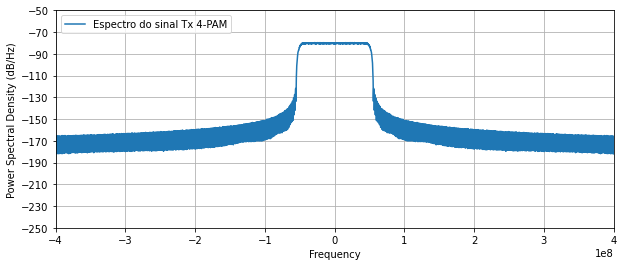

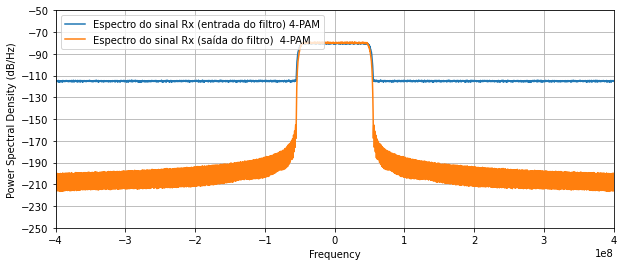

In [12]:
# plot PSD
plt.figure();
plt.xlim(-4*Rs,4*Rs);
plt.ylim(-250,-50);
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Tx '+ str(M) +'-PAM')
plt.legend(loc='upper left');

plt.figure();
plt.xlim(-4*Rs,4*Rs);
plt.ylim(-250,-50);
plt.psd(sigTx+ruido,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (entrada do filtro) '+ str(M) +'-PAM')
plt.psd(pnorm(firFilter(pulse, sigTx+ruido)),Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (saída do filtro)  '+ str(M) +'-PAM')
plt.legend(loc='upper left');

## Referências

[1] J. G. Proakis, M. Salehi, Communication Systems Engineering, 2nd Edition, Pearson, 2002.